<a href="https://colab.research.google.com/github/restful3/ds4th_study/blob/main/source/%ED%85%90%EC%B4%88%EC%9D%98%20%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D%20%ED%8A%B9%EA%B0%95/plant_pathology_2020_fgvc7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement<br>
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.<br>|
잎사귀 사진으로 잎사귀가 어떤 질병에 결렸는지 판별<br>
- healthy : 건강한 잎사귀
- multiple_diseases : 여러 질병에 걸린 잎사귀
- rusk : 녹병에 걸린 잎사귀
- scab : 붉은 곰팡기병에 걸린 잎사귀 

### Specific Objectives<br>
Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset to 

1. Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 
2. Accurately distinguish between many diseases, sometimes more than one on a single leaf; 
3. Deal with rare classes and novel symptoms;
4. Address depth perception—angle, light, shade, physiological age of the leaf; and 
5. Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.

### tactics <br>
> 평가지표 ROC_AUC<br>
> 데이터 변환기 Albumentations 활용<br>
> 모델 : EfficientNet-B7활용<br>
> 훈련 : 교차엔트로피오차,AdamW<br>
> 예측 : TTA(테스트단계 데이터 증강), 레이블 스무딩


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## 케글데이터-코랩 연동 참고사이트:  https://kubig-2021-2.tistory.com/35
# !pip install kaggle
# from google.colab import files
# files.upload()  # kaggle.json 파일을 업로드 합니다.

In [ ]:
# ls -1ha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-pathology-2020-fgvc7
!cp plant-pathology-2020-fgvc7.zip /content/drive/MyDrive/SelfStudy/캐글스터디/  #  집파일을 원하는 위치로 이동합니다. 
!cp .kaggle/kaggle.json /content/drive/MyDrive/SelfStudy/캐글스터디/.kaggle/

!unzip /content/drive/MyDrive/SelfStudy/캐글스터디/plant-pathology-2020-fgvc7.zip # 집파일을 해제합니다.

## 1. 데이터 확인

In [ ]:
# 구글드라이브에서 csv를 자동 변환하는 url따오는 방법 : https://lapina.tistory.com/196
# 데이터 로드 및 분포 확인
import pandas as pd
import numpy as np
tr_url = 'https://docs.google.com/spreadsheets/d/15Jvpu7tN_vpDDf2tPhIpSnxuHjVev5g1XJpwm3AXuGg/export?format=csv&gid=829107032'
te_url = 'https://docs.google.com/spreadsheets/d/1GcclmeX-c9bvoTg6qVzPhInkeWmoP_4A9kUJ4iRcIBY/export?format=csv&gid=1285790145'
sub_url = 'https://docs.google.com/spreadsheets/d/1EFALaBdFtQbznP1SxGhC2Vh-CLW8Xjjc-vBzHNwZnk4/export?format=csv&gid=177907317'

path = '/content/drive/MyDrive/SelfStudy/캐글스터디/plant-pathology-2020-fgvc7/'
train = pd.read_csv(tr_url)
test = pd.read_csv(te_url)
submission = pd.read_csv(sub_url)
train.shape,test.shape

((1821, 5), (1821, 1))

### 1.1 데이터 분포 확인

1821

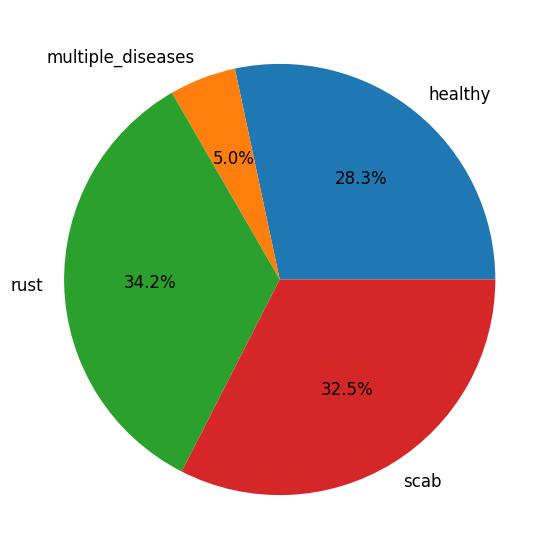

In [ ]:

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]


mpl.rc('font',size=12)
plt.figure(figsize=(7,7))

label = ['healthy','multiple_diseases','rust','scab']
plt.pie([len(healthy),len(multiple_diseases),len(rust),len(scab)],
        labels=label,
        autopct='%.1f%%');
len(healthy)+len(multiple_diseases)+len(rust)+len(scab)

### 1.2 이미지 확인

In [ ]:

from matplotlib.gridspec import GridSpec
import cv2

def show_image(img_ids,rows=2,cols=3):
    assert len(img_ids) <= rows * cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    plt.figure(figsize=(15,8))
    grid = GridSpec(rows,cols)
    
    for idx, img_id in enumerate(img_ids):
        img_path = f'{path}images/{img_id}.jpg'
#         print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

num_img = 6
last_healthy_img_ids = healthy['image_id'][-num_img:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_img:]
last_rust_img_ids = rust['image_id'][-num_img:]
last_scab_diseases_img_ids = scab['image_id'][-num_img:]  

In [ ]:
show_image(last_healthy_img_ids)

error: ignored

<Figure size 1500x800 with 0 Axes>

In [ ]:
show_image(last_multiple_diseases_img_ids)

In [ ]:
show_image(last_rust_img_ids)

In [ ]:
show_image(last_scab_diseases_img_ids)

## 2. 베이스 모델 모델링

### 2.1 이미지데이더셋 준비

In [ ]:
import torch
import random
import os 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### 2.1.1 이미지데이터셋 로드 : Dataset

> 이미지 파일을 train.csv, test.csv파일의 파일명으로 로드하여 RGB이미지 객체생성


In [ ]:
import cv2
from torch.utils.data import Dataset
import numpy as np

class imagedataset(Dataset):
    def __init__(self, df, img_dir='./',transform = None,is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_id = self.df.iloc[idx,0]
        img_path = self.img_dir + img_id +'.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None: # 변환이 있으면 적용
            image = self.transform(image=image)['image']
        
        if self.is_test: # 테스트면 이미지 리턴하고 아니면 이미지, 라벨 리턴
            return image
        else :
            label = np.argmax(self.df.iloc[idx,1:5])
            return image, label


####  2.1.2 이미지 증강 (Augmentation)
> epoch 시마다 이미지를 변환하여 과대적합을 방지 <br>
> 배치정규화로 (평균 0, 분산 1로 맞추어서) 과대적합을 방지<br>

-  훈련데이터에서는 이미지 변환을 충분히 진행하기에 epoch이 늘어나도 과적합이 일어나지 않고, 정확도가 올라간다. 이만으로는 충분치 않기에 배치정규화까지 매 단계에서 진행해주며 과적합을 방지한다. 테스트 변환기는  모델과 스케일을 맞추기 위한 목적의 배치정규화를 진행

[PyTorch 데이터로더 이해하기 참고](https://blog.promedius.ai/pytorch_dataloader_1/)<br>
[PyTorch 데이터로더 이해하기 참고2](https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html)

In [ ]:
# 이미지 변환을 위한 모듈
import albumentations as A
from albumentations.pytorch import ToTensorV2 # 이미지데이터를 텐서로 보냄

# 학습용 변환기 : 특정 확률로 속성, 이동, 여파인 변환 적용  
transform_train = A.Compose([    # 리스트에 각기능 담음
    A.Resize(450,450),           # 리사이즈      
    A.RandomBrightnessContrast(brightness_limit=0.2,  # 밝기 및 콘트라스트
                              contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),       # 상하대칭
    A.HorizontalFlip(p=0.5),     # 좌우대칭
    A.ShiftScaleRotate(          # 이동, 스케일링,회전변환로 랜덤 선택하여 바꿈 (30% 확율 지정)
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30,p=0.3),
    A.OneOf([                    # 양각화,날카로움, 블러 중 하나를 랜덤으로 선택하여 바꿈 (30%확률 지정)
        A.Emboss(p=1),
        A.Sharpen(p=1),
        A.Blur(p=1)],p=0.3),
    A.PiecewiseAffine(p=0.3),    # 여파인 변환 : 이동확대축소, 회전등으로 이미지 모양을 전체적으로 바꾸는 것
    A.Normalize(),              # 배치정규화하여
    ToTensorV2()                # 텐서로 보냄
    ])

# 테스트용 변환기: 증강 등변환 없이 사이즈만 조정
transform_test = A.Compose([
    A.Resize(450,650),            # 리사이즈 
    A.Normalize(),                # 배치정규화하여
    ToTensorV2()                  # 텐서로 보냄
])

In [ ]:
from sklearn.model_selection import train_test_split
img_dir = f'{path}/images/'
train, valid = train_test_split(train,
                               test_size=0.1,
                               stratify=train[['healthy','multiple_diseases','rust','scab']],
                               random_state=50)
dataset_train = imagedataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = imagedataset(valid , img_dir=img_dir, transform=transform_test)


In [ ]:
# 멀티프로세싱을 활용하기 위해 데이터 로더의 시드를 고정 
# 데이터 제너레이터 정의 
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 **32
    np.random.seed(worker_seed)
    random.seed(worker_seed)    
g= torch.Generator()
g.manual_seed(0)

#### 2.1.3 이미지 배치화 : DataLoader

- 학습전 데이터셋단위에 배치를 적용 : 한 스탭에 몇개 적용하는지로 성능에 영향을 미침
  + 클수록 속도는 빨라지나 너무 크면 모델성능이 나빠지며 GPU램이 감당못함 (힌튼교수 32이하 권장)  

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4 # 데이터 사이즈가 1841개로 작아서 배치 줄임 (그거야 ~~ GPU가 좋은 때 말이지...3060은 어림도 없음!)

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                         shuffle=True, worker_init_fn = seed_worker,
                         generator=g, num_workers=2)

loader_valid = DataLoader(dataset_valid , batch_size=batch_size,
                         shuffle=True, worker_init_fn = seed_worker,
                         generator=g, num_workers=2)

### 2.2 모델 학습
> 비교적 적은 파라미터로 좋은 성능을 지닌 EfficientNet 알고리즘을 다운받아서 학습한다. <br><br>
[EfficientNet 알아보기 (논문 및 코드)](https://paperswithcode.com/method/efficientnet)<br>
효과적인 복합 계수를 사용하여 깊이/폭/해상도의 모든 차원을 균일하게 스케일링하는 방법으로 성능을 개선한 모델. 특히, EfficientNet-B7은 이미지넷에서 84.3%의 최고 정확도를 달성하는 동시에 기존 최고 ConvNet보다 8.4배 더 작고 추론 속도가 6.1배 더 빠름. 기존모델대비 훨씬 적은 수의 파라미터로 CIFAR-100(91.7%), Flowers(98.8%) 및 기타 3개의 전송 학습 데이터 세트에서 우수한 전송 성능과 최고의 정확도 달성

#### 2.2.1 모델준비 : EfficientNet
- 모델 : EfficientNet
- epochs = 3
- 손실함수 : CrossEntropyLoss()
- 활성화함수 : AdamW
- 학습율 lr = 0.00006
- 가중치감소 weight_decay = 0.0001

In [ ]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=7859a46228ee2602e30b73b44fddc6f8d331be4c40836a4f08356839958dd430
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) # 기본 출력피처는 1000개이나, 우리가 예측이 필요한 피쳐는 4개로, num_classes를 4로 지정

# # num_classes를 활성화함수, drop_out등 옵션을 주면서 파인튜닝 가능

# model = EfficientNet.from_pretrained('efficientnet-b7')
# model._fc= nn.Sequentail(
# nn.Linear(model._fc.in_features, model._fc.out_features),
# nn.ReLu(),
# nn.DropOut(0.5),
# nn.Linear(model.fc.out_features,4))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:03<00:00, 71.2MB/s]


Loaded pretrained weights for efficientnet-b7


In [ ]:
# 에폭, 손실함수, 최적화함수, 학습률 
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm


model = model.to(device) # 모델을 디바이스로 보내고

epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00006, weight_decay = 0.0001)

#### 2.2.2 모델훈련 및 성능 검증



In [ ]:
for epoch in range(epochs):

    model.train()
    epoch_train_loss =0
    
    for images, labels in tqdm(loader_train):
        images = images.to(device) # 이미지도 디바이스로 보내고
        labels = labels.to(device) # 라벨도 디바이스로 보내고 
        optimizer.zero_grad()      # 옵티마이저 초기화해주고 (과적합 방지)

        outputs = model(images)    # 모델로 예측 산출
        loss = criterion(outputs, labels) # 로스율 산출 (예측, 라벨)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}') 
    
    
    # =========[검증]========================
    model.eval()          # 모델용 평가상태로 설정
    epoch_valid_loss = 0  # 에폭 별 손실값 초기화
    preds_list = []       # 예측 확률값 저장용
    true_onehot_list =[]  # 실제 타깃 저장용
    
    with torch.no_grad():
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
                    
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            # 예측값과 실제값의 저장
            preds = torch.softmax(outputs.cpu(), dim =1).numpy()
            true_onehot = torch.eye(4)[labels.cpu()].numpy()  
            
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    print(f'에폭 [{epoch+1}/{epochs}] - 검증데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증데이터 ROC_AUC : {roc_auc_score(true_onehot_list,preds_list):.4f}') 

  0%|          | 0/410 [00:00<?, ?it/s]

error: ignored

#### 2.2.3  예측 및 결과 제출

In [ ]:
dataset_test = imagedataset(test,img_dir=img_dir,
                           transform = transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size,
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=2)
model.eval()
preds = np.zeros((len(test),4))

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i * batch_size:(i+1) * batch_size] += preds_part

error: ignored

In [ ]:
# 결과제출
submission[['healthy','multiple_diseases','rust','scab']] = preds
submission.to_csv('submission.csv', index=False)

## 3. 성능개선 모델 모델링
1. 에폭 늘리고, 스케줄러 추가
2. TTA (테스트 예측단계 데이터 증강) 기법
3. 레이블 스무딩 적용

### 3.1 에폭 늘리고 스케줄러 추가
<b>스케줄러</b>는 훈련과정에서 학습률을 조정하는 역할을 함 <br>
초반에 크게 주다가, 뒤에 적게 주면 Global Optimal을 찾는데 유리!!! <br>
골프 칠 때 드라이브로 때리고,  짧은 아이언으로 나중에 치는 게 유리하듯~


In [ ]:
!pip install transformers
from transformers import get_cosine_schedule_with_warmup
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) # 기본 출력피처는 1000개이나, 우리가 예측이 필요한 피쳐는 4개로, num_classes를 4로 지정
model = model.to(device) # 모델을 디바이스로 보내고

epochs = 10 # 총 에폭
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00006, weight_decay = 0.0001)

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*3, 
                                            num_training_steps=len(loader_train)*epochs)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
Loaded pretrained weights for efficientnet-b7


In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward()  # 역전파 수행
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu()].numpy() 
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/410 [00:00<?, ?it/s]

error: ignored

### 3.2 TTA (테스트 예측단계 데이터 증강) 기법
> 훈련데이터가 많으면 성능이 좋아지듯, 테스트 단계에서도 예측성능향상 가능 <br>
> Test Time Augmentation : 테스트 데이터를 변형한 뒤 예측하여 테스트 데이터가 늘어나는 효과<br>

> 테스트 데이터에 여러 변환 적용 ~ 변환된 테스트 데이터 별로 타겟 확율값 예측 ~
 타깃 예측 확률의 평균 산출

In [ ]:
# 테스트 데이터 원본 데이터셋 및 데이터 로더
dataset_test = imagedataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True) # 원본데이터는 트랜스폼을 테스트로 보내고
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

# TTA용 데이터셋 및 데이터 로더
dataset_TTA = imagedataset(test, img_dir=img_dir, 
                           transform=transform_train, is_test=True) # TTA데이터는 트랜스폼을 학습용으로 보냄 (변환 적용) 
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정 

preds_test = np.zeros((len(test), 4)) # 예측 값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

error: ignored

In [ ]:
submission_test = submission.copy() # 제출 샘플 파일 복사

submission_test[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_test

In [ ]:
num_TTA = 7 # TTA 횟수

preds_tta = np.zeros((len(test), 4)) # 예측 값 저장용 배열 초기화 (TTA용)

# TTA를 적용해 예측
for i in range(num_TTA):
    with torch.no_grad():
        for i, images in enumerate(loader_TTA):
            images = images.to(device)
            outputs = model(images)
            # 타깃 예측 확률
            preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
            preds_tta[i*batch_size:(i+1)*batch_size] += preds_part

error: ignored

In [ ]:
preds_tta /= num_TTA # preds_tta룰 구할 때, num_TTA만큼 누적했으니 다시 나눠줌

In [ ]:
submission_tta = submission.copy() 

submission_tta[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_tta

In [ ]:
submission_test.to_csv('submission_test.csv', index=False)
submission_tta.to_csv('submission_tta.csv', index=False)

### 3.3 데이터스무딩
딥러닝모델이 과잉 확신하는 경우가 있음. (특정 타깃값일 확률을 1에 매우 가깝게 예측) <br>일반화 성능을 높히려면 과잉 확신한 예측값을 보정 필요함 <br>
레이블 강도를 $\alpha$라 할 때 레이블스무딩을 적용하는 수식은 다음과 같음<br> <br> 
> $(1-\alpha) * preds + \frac{\alpha}{K} $ <br><br>

$\alpha$가 0이면 보정한 값이 예측값과 같고 1이면 모든 타겟예측값이 1/K로 같아짐<br>
[iterrows()메소드로 (인덱스,값) 튜플 가져오기](https://wikidocs.net/158775) 

In [ ]:
def apply_label_smoothing(df, target, alpha, threshold):
    df_target = df[target].copy() # 타깃값 복사
    k = len(target) # 타깃값 개수
    
    for idx, row in df_target.iterrows():
        if (row > threshold).any():         # 임계값을 넘는 타깃값인지 여부 판단
            row = (1 - alpha)*row + alpha/k # 레이블 스무딩 적용  
            df_target.iloc[idx] = row       # 레이블 스무딩을 적용한 값으로 변환
    return df_target # 레이블 스무딩을 적용한 타깃값 반환

In [ ]:
alpha = 0.001 # 레이블 스무딩 강도
threshold = 0.999 # 레이블 스무딩을 적용할 임계값

# 레이블 스무딩을 적용하기 위해 DataFrame 복사
submission_test_ls = submission_test.copy()
submission_tta_ls = submission_tta.copy()

target = ['healthy', 'multiple_diseases', 'rust', 'scab'] # 타깃값 열 이름

# 레이블 스무딩 적용
submission_test_ls[target] = apply_label_smoothing(submission_test_ls, target, 
                                                   alpha, threshold)
submission_tta_ls[target] = apply_label_smoothing(submission_tta_ls, target, 
                                                  alpha, threshold)

submission_test_ls.to_csv('submission_test_ls.csv', index=False)
submission_tta_ls.to_csv('submission_tta_ls.csv', index=False)